<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# 1.  [High Dimensional and Deep Learning](https://github.com/wikistat/High-Dimensional-Deep-Learning ):  [Reconnaissance d'Activité Humaine](https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/FunctionalDecomposition/Python%20-%20HAR.ipynb) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>   Anomaly Detection

## 1.1 Context


The objective is to recognize the activity of an individual from a set of signals recorded on a smartphone from the embedded gyroscope and accelerometer. A learning database has been built experimentally. A set of persons  performed a determined activity for a predefined period of time while signals were recorded. The data come from the community that aims to recognize human activities (Human activity recognition, HAR). See the [paper](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) on a symposium in 2013. The analysis of data associated with real-time activity identification is not discussed.

The available public data was acquired, described and partly analyzed by [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf). They are available on the University California Irvine (UCI) [repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dedicated to machine learning.

The archive contains the raw data: accelerations sampled at 64 htz during 2s. The accelerations in x, y, and z (body_acc), each contains 128 columns, those by subtracting the natural gravity (total_acc) as well as the angular accelerations in x, y, and z obtained from the gyroscope (body_gyro). The choice of a power of 2 for the sampling frequency allows the efficient execution of Fourier transform or wavelet transform algorithms.


The *features data* have been built by experts of signal processing from the *a priori* knowledge on the behaviour of the different activities we want to study. We will see that it is quite easy to achieve good performances for the anomaly detection problem using these features data.


The objective of this TP is to detect anomalies from the *features* data and from simple transformations of the raw data. 

## 1.2 Objectives : 

- Apply several anomaly detection methods on the *features* data :  
  - Hierarchical clustering (CAH : Classification ascendante hiérarchique)
  - One-class SVM
  - Local Outlier Factor
  - Isolation Forest
  
 
- Anomaly detection on the functional data : transformation of the raw data onto new features (PCA, wavelet decomposition, Fast Fourier Transform) on which we apply the previous mentioned anomaly detection methods.


- As in the previous TP for classification purposes, the objective is here to obtain as good performances for anomaly detection as on  the *features* data with simple transformations of the raw signals. 


# 2. Introduction

## 2.1 Libraries

In [1]:
import pandas as pd
import numpy as np

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
import utils.illustration as uil
import utils.load as ul

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

In [2]:
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z"]
CMAP = plt.get_cmap("Set1")
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}
COLOR_DIC = {v:CMAP(k-2) if v!="WALKING" else CMAP(10) for k,v in ACTIVITY_DIC.items()}

## 2.2  The data
### 2.2.1 Loading the data


In [3]:
data_path = "../data/HumanActivityRecognition"
#Multidimensional Data
X_train = ul.load_signals(data_path,"train", SIGNALS)
Y_train_label = ul.load_y(data_path, "train")
X_train_metier = ul.my_read_csv(data_path+"/train/X_train.txt").values

/home/monedier/Bureau/High-Dimensional-Deep-Learning/AnomalyDetection/utils/load.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y = y.as_matrix()


### 2.2.2 Constitution of the datasets with anomalies

We build a dataset with

   * `N_normal` signals considered as *normal*  (corresponding to the class *WALKING*).  
   * `N_anormal` signals of each type of *abnormal* signals  (*WALKING UPSTAIRS*, *WALKING DOWNSTAIRS*, *SITTING*, *STANDING*, *LAYING*)


In [4]:
N_normal = 800
N_anormal = 2

# New Y Label
Y= np.hstack([np.repeat(1,N_normal)] + [np.repeat(i, N_anormal) for i in range(2,7)])
Y_label = np.array([ACTIVITY_DIC[y] for y in Y])
#New X Data
index_per_act = np.hstack([np.where(Y_train_label==1)[0][:N_normal]] + [np.where(Y_train_label==act)[0][:N_anormal] for act in range(2,7)])

X = X_train[index_per_act]
X_metier = X_train_metier[index_per_act]


For each type of signal, a sample of the normal behavior and the different anomalies are displayed.

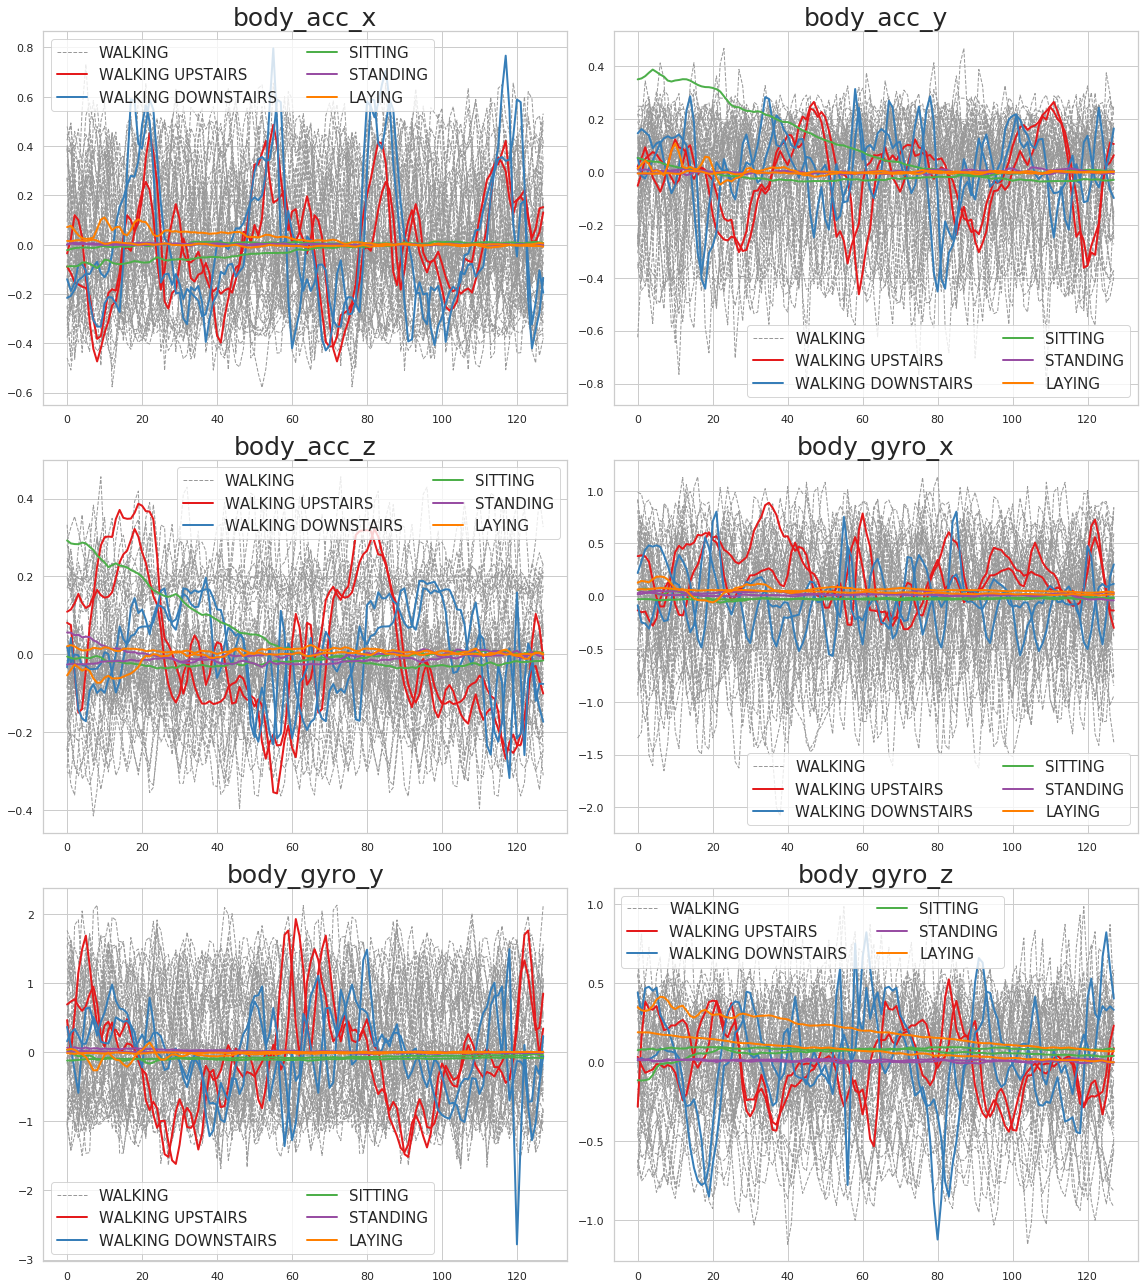

In [5]:
nb_sample_per_activity = dict([(v,50) if v=="WALKING" else (v,N_anormal) for k,v in ACTIVITY_DIC.items()])
linestyle_per_activity = dict([(v,"dashed") if v=="WALKING" else (v,"solid") for k,v in ACTIVITY_DIC.items()])
linewidth_per_activity = dict([(v,1) if v=="WALKING" else (v,2) for k,v in ACTIVITY_DIC.items()])

fig = plt.figure(figsize=(16,18))    
uil.plot_signaux(fig, X, Y_label, SIGNALS, COLOR_DIC, nb_sample_per_activity, 
             linestyle_per_activity, linewidth_per_activity, figdim1 = 3, figdim2 = 2, legend=True)


## 2.3 Principal components analysis
### 2.3.1  For the signal : acceleration in  x

In [6]:
isignal = 0
print("ACP on signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

acp = sd.PCA()
X_acp_signal = acp.fit_transform(sp.scale(X_signal))

X_signal.shape

ACP on signal body_acc_x


(810, 128)

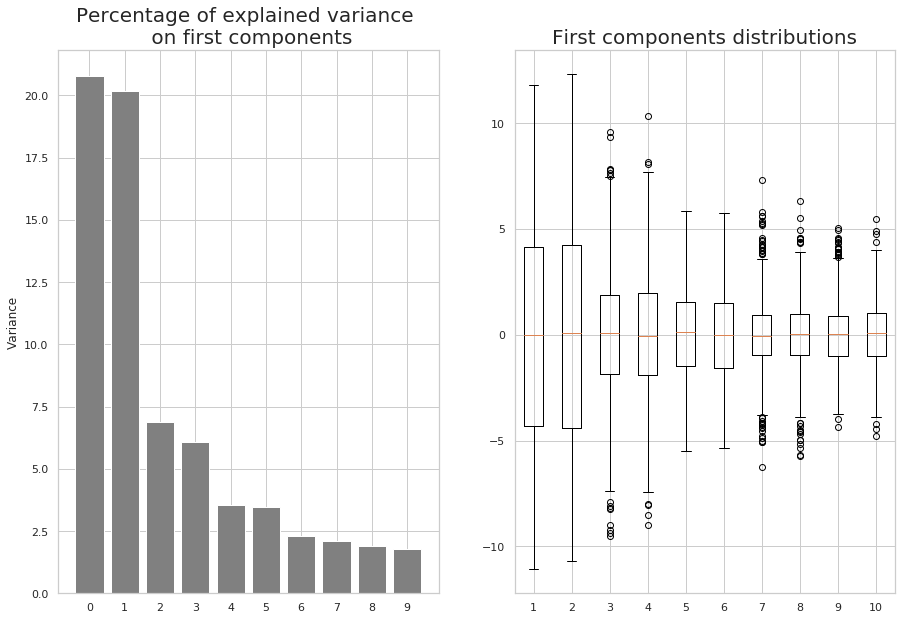

In [7]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signal)

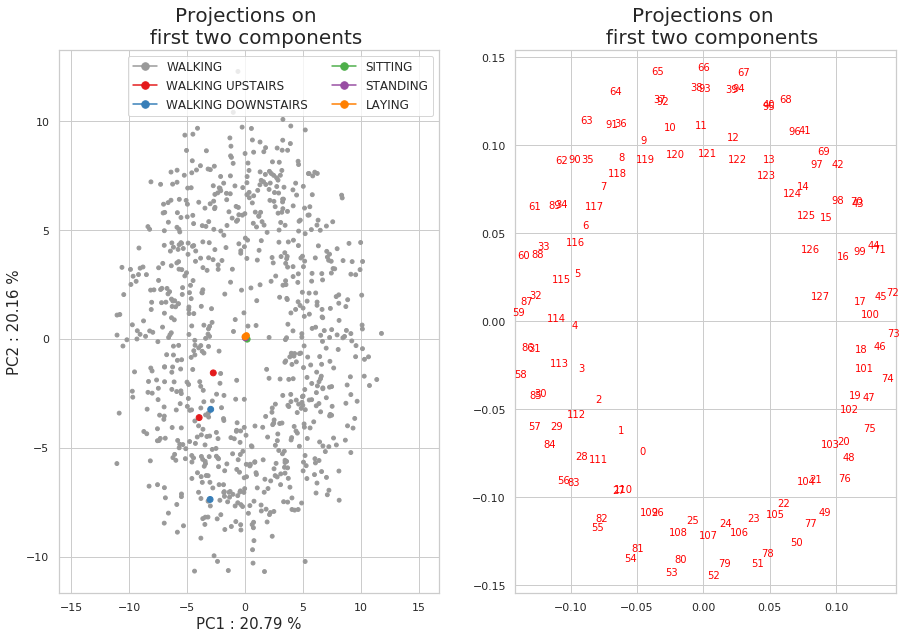

In [8]:
N = X.shape[0]
colors=[COLOR_DIC[y] for y in Y_label]
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signal, acp, colors=colors, markersizes = markersizes, color_dic=COLOR_DIC)

**Q.** Comment these results from the perspective of anomaly detection

**R** Les anomalies ne sont pas séparées des observations normales, ces résultats ne sont pas très intéressants. 

### 2.3.2  For all the signals

In [9]:
X_signaux = np.vstack([x.reshape(128*6) for x in X])
acp = sd.PCA()
X_acp_signaux = acp.fit_transform(sp.scale(X_signaux))

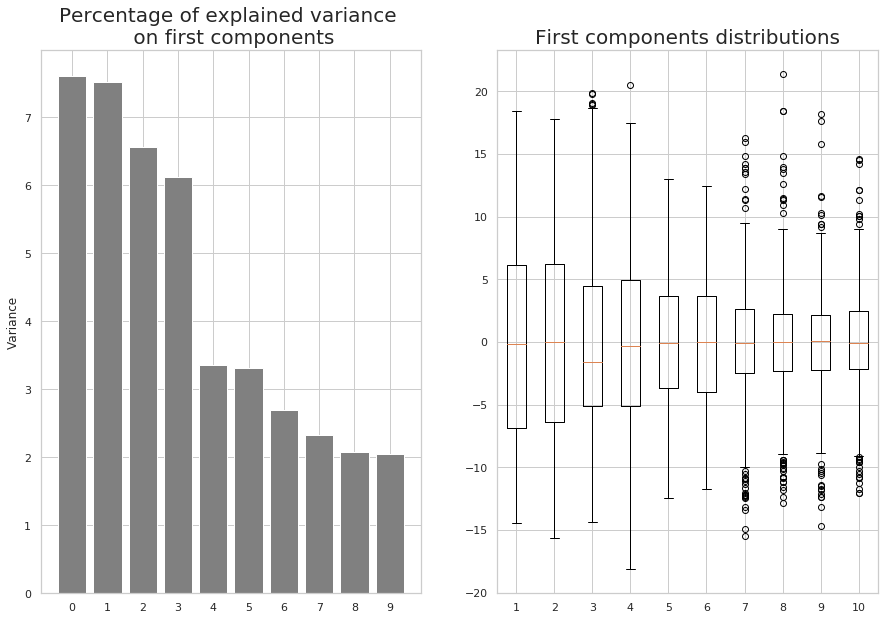

In [10]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_signaux)

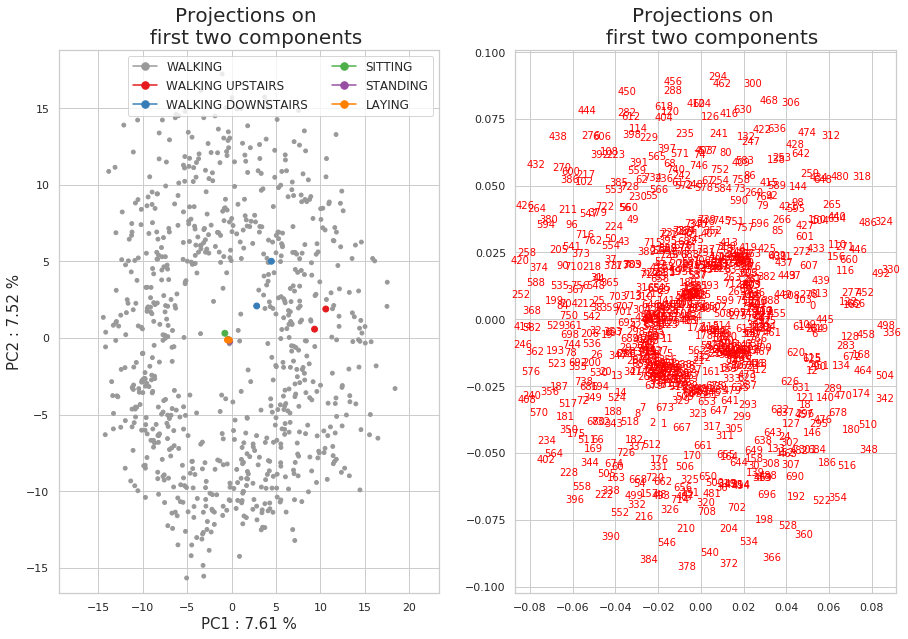

In [11]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_signaux, acp, colors, markersizes, color_dic=COLOR_DIC)

### 2.3.3 For the *features* data

In [12]:
acp = sd.PCA()
X_acp_metier = acp.fit_transform(sp.scale(X_metier))

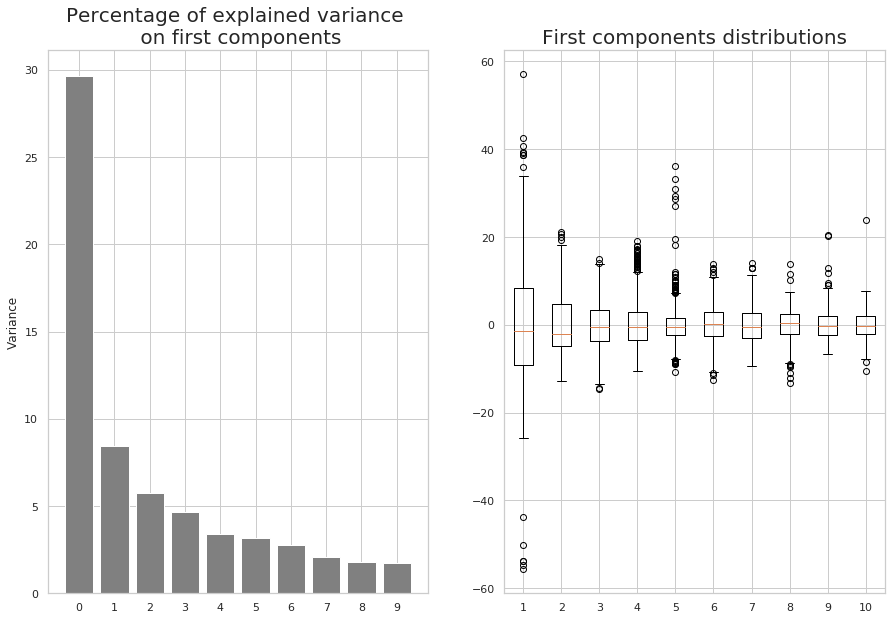

In [13]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_metier)

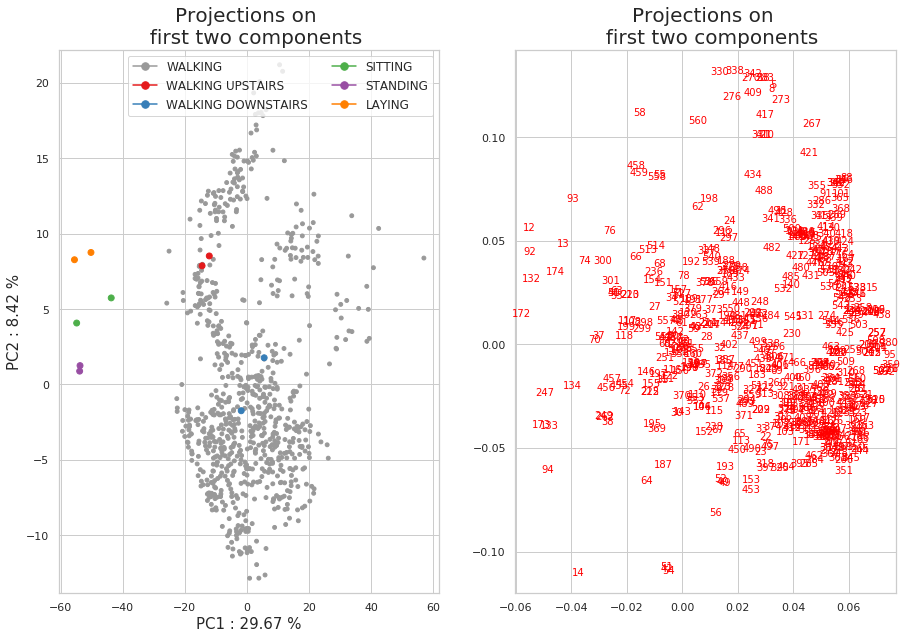

In [14]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_metier, acp, colors, markersizes, color_dic=COLOR_DIC)

**Q.** Comment these results from the perspective of anomaly detection

Beaucoup mieux avec les features métier, on voit que les 3 types d'anomalies correspondant aux états de repos sont très bien séparées des autres observations. On remarque aussi que la décroissance de la variance expliquée est beaucoup plus rapide que précédemment.

# 3. Anomaly detection of the *features* data 

It seems quite easy to detect the anomalies from the *features* data. We apply the classical methods studied during the course: hierarchical clustering with the "single" option,  One class SVM, Local Outlier Factor and Isolation Forest. 
The different methods have not been optimized. Study the impact of the different parameters on the anomaly detection performances. 


## 3.1 Hierarchical clustering (Classification Ascendante Hiérarchique)

In [15]:
Z = sch.linkage(X_metier, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             0        0         0      799                   2   
1             0        0         0        1                   0   
2             0        1         0        0                   0   
3             0        1         2        0                   0   
4             1        0         0        0                   0   
5             1        0         0        0                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

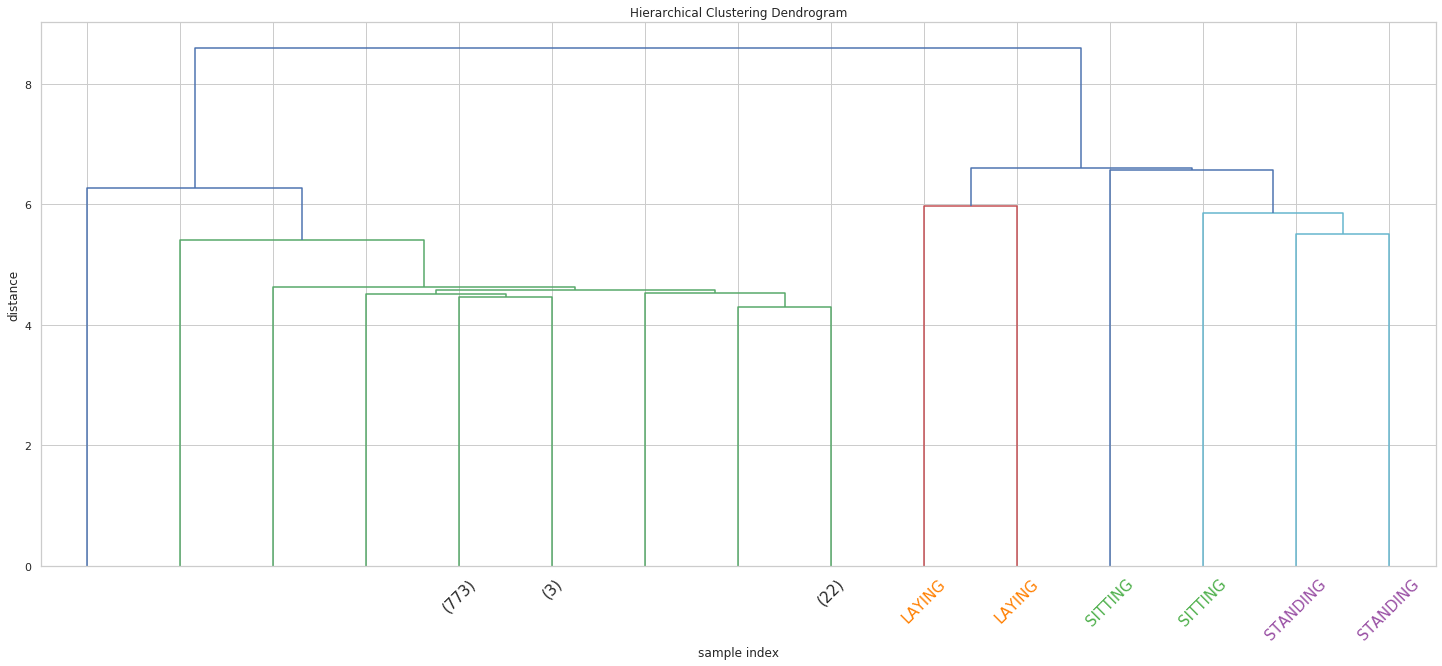

In [16]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

## 3.2  One class SVM

In [30]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05, gamma=1e-2)

OCS.fit(X_metier)
pred = OCS.predict(X_metier)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       35                   0   
 1            0        0         0      765                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

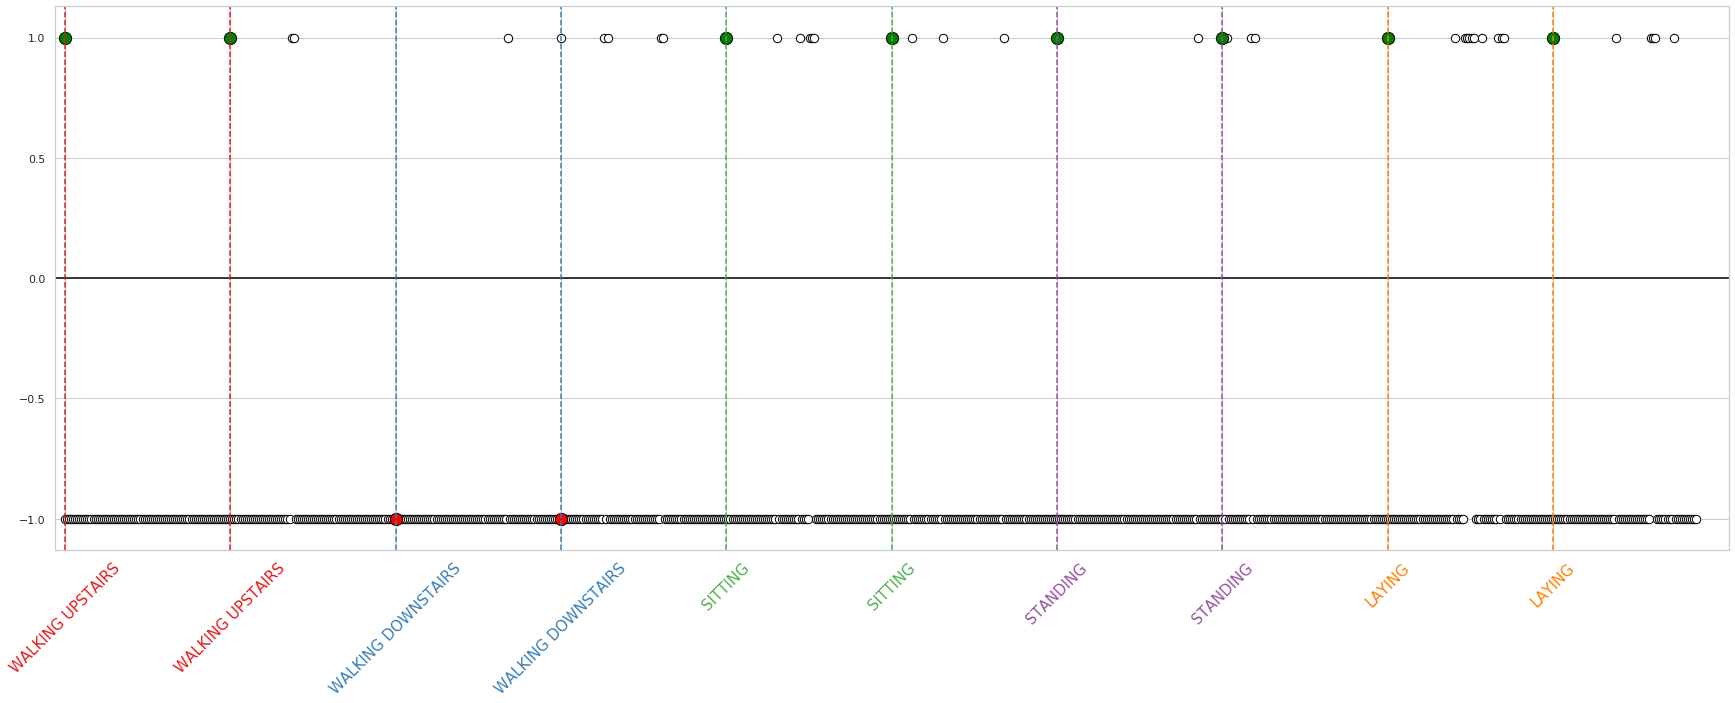

In [28]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_svm,COLOR_DIC, normal_behaviour="WALKING")


## 3.3 Local Outlier Factor

In [44]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_metier)

CT_metier_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_metier_lof.pred, CT_metier_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       31                   2   
 1            0        0         0      769                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      2  
 1                      0

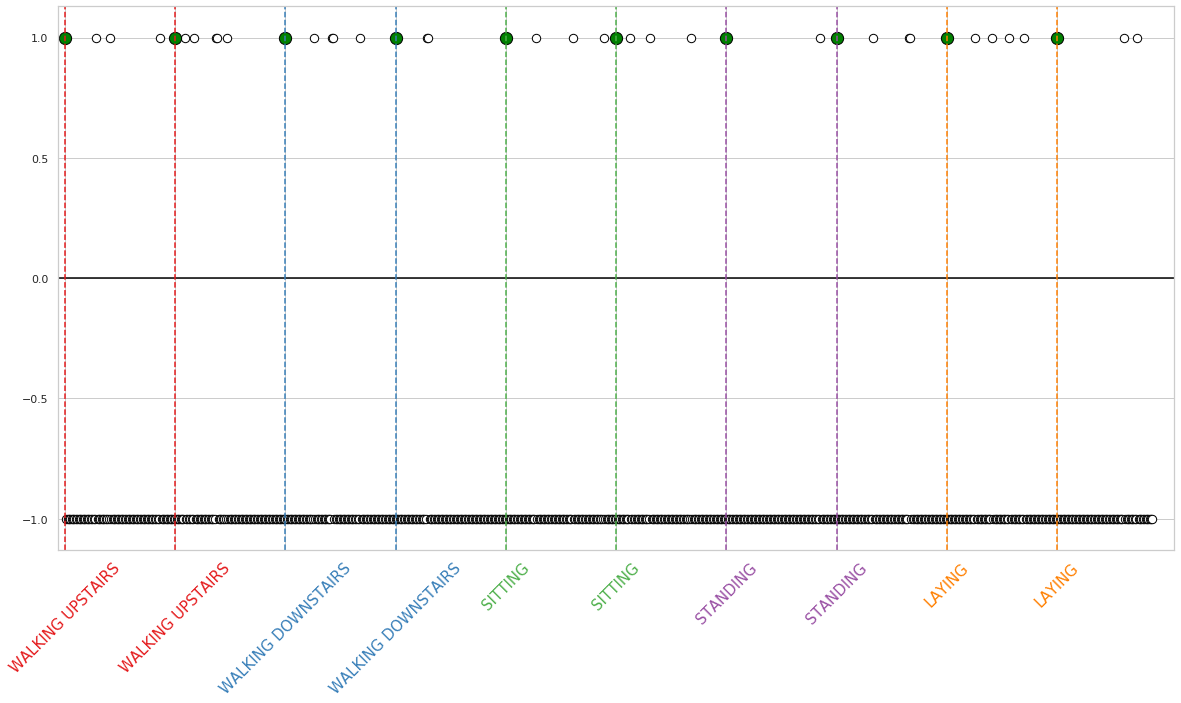

In [45]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_metier_lof, COLOR_DIC, normal_behaviour="WALKING")


## 3.4 Isolation Forest

In [51]:
clf = se.IsolationForest(n_estimators=100, contamination=0.013, bootstrap=True, n_jobs=-1)

clf.fit(X_metier)
y_pred = clf.predict(X_metier)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2        5                   0   
 1            0        0         0      795                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

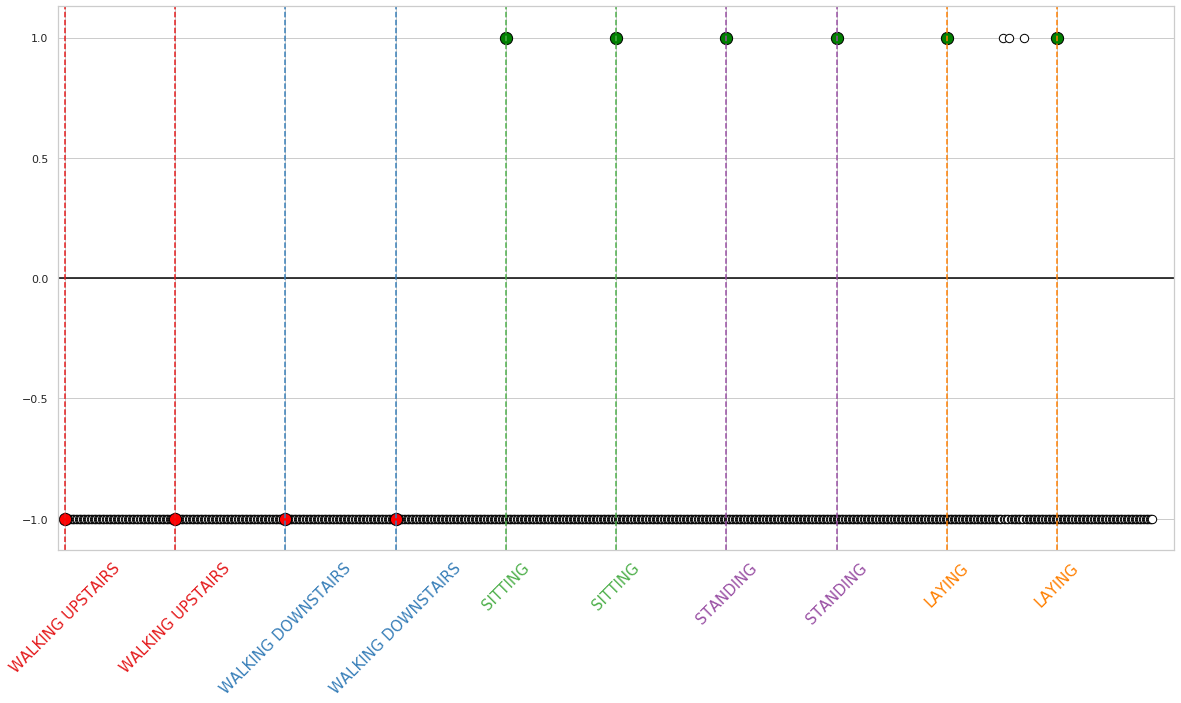

In [50]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_IF, COLOR_DIC, normal_behaviour="WALKING")


**Q.** What is your  conclusion on the *features* data ? 

**R** Ca marche vraiment bien, on valide.

The objective of the next sections is to try to detect the  anomalies from the raw data or from simple transformations of the raw data. 


# 4. Anomaly detection on the raw data

## 4.1 Hierarchical clustering

We first use a single signal : acceleration in x


In [42]:
Z = sch.linkage(X_signal, 'single')

C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             2        2         2      793                   2   
1             0        0         0        3                   0   
2             0        0         0        1                   0   
3             0        0         0        1                   0   
4             0        0         0        1                   0   
5             0        0         0        1                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

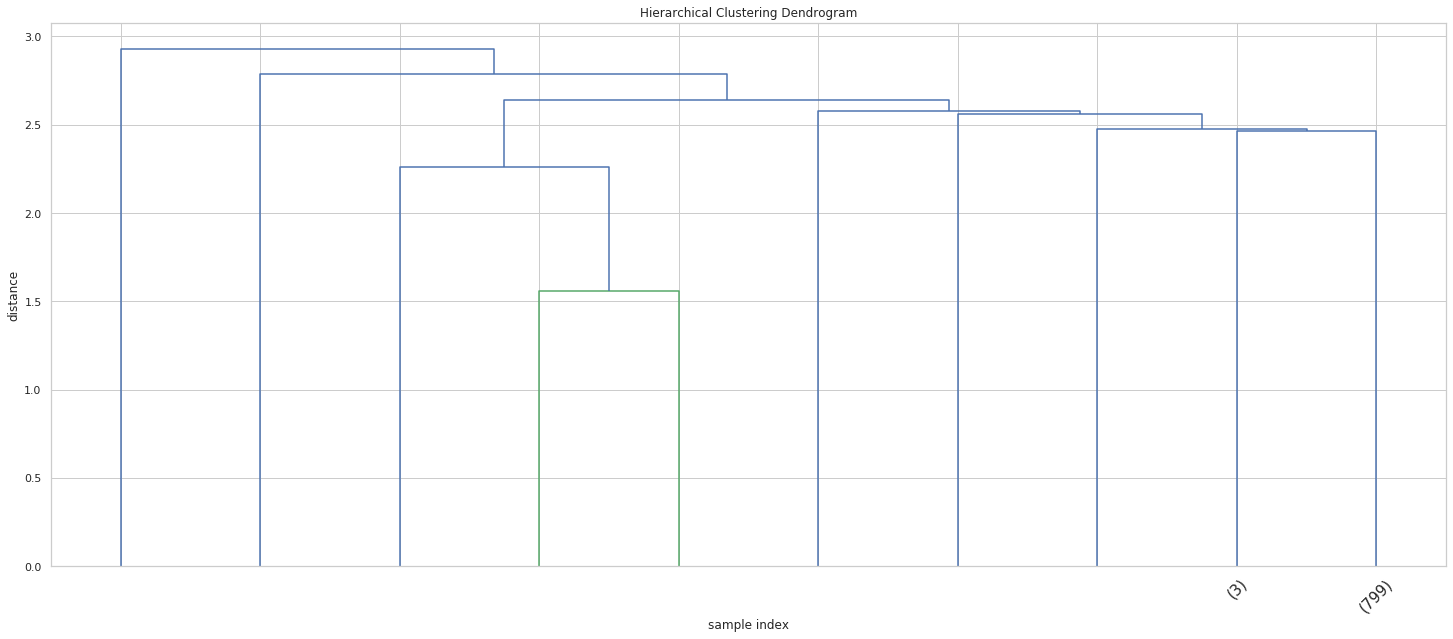

In [43]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

In [46]:
X_signaux = np.vstack([x.reshape(128*6) for x in X])

In [47]:
Z = sch.linkage(X_signaux, 'single')

C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             2        2         2      794                   2   
1             0        0         0        1                   0   
2             0        0         0        1                   0   
3             0        0         0        2                   0   
4             0        0         0        1                   0   
5             0        0         0        1                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

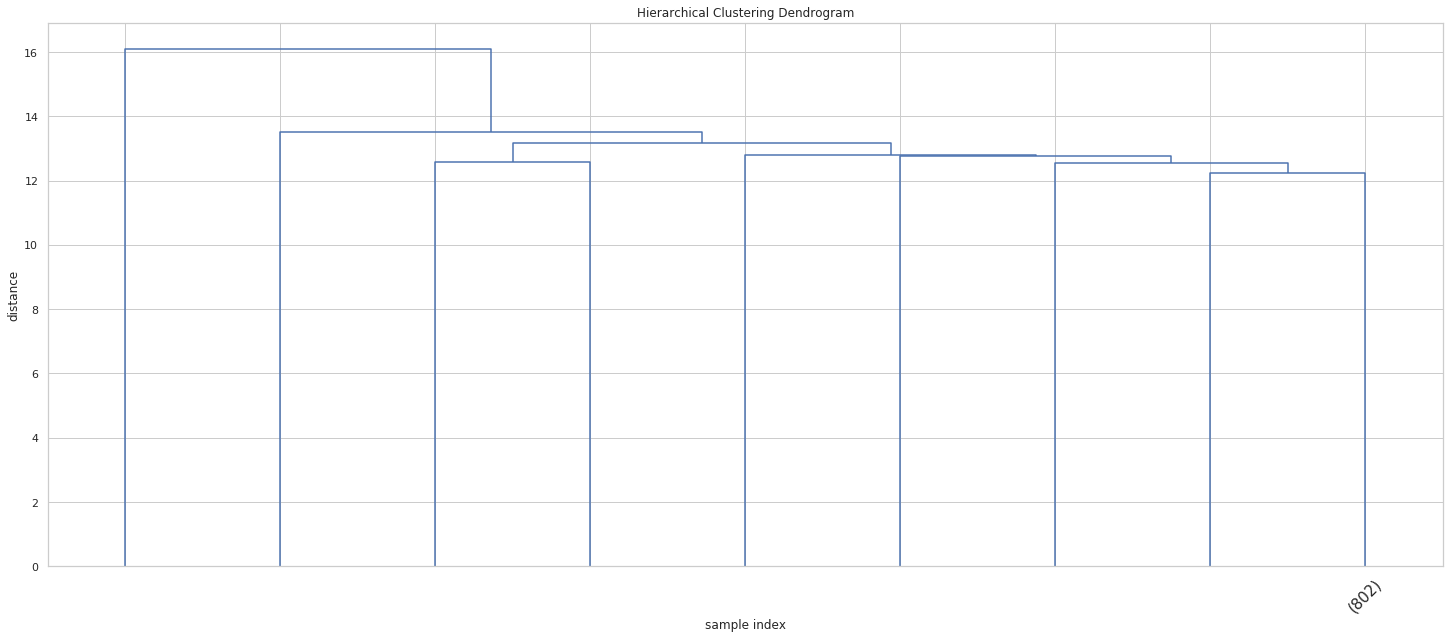

In [48]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

**Q.** How many anomalies have been detected? Do you get better results by taking all the signals?

**R** Aucune, un score même pas légèrement au-dessus de zéro. C'est un tout petit peu moins pire, mais hyper nul quand même.


## 4.2 One class SVM

### 4.2.1 On the two first PCA components

In [59]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.01)

nb_compo = 2
OCS.fit(X_acp_signal[:,:nb_compo])
pred = OCS.predict(X_acp_signal[:,:nb_compo])

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0      281                   2   
 1            2        2         2      519                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      1  
 1                      1

**Q.** Comment on the results. Do you get better results by increasing the number of components?

**R** Non  : ce n'est pas mieux même en gardant plus de composantes

Text(0.5, 1.0, 'Novelty Detection : nu=0.0')

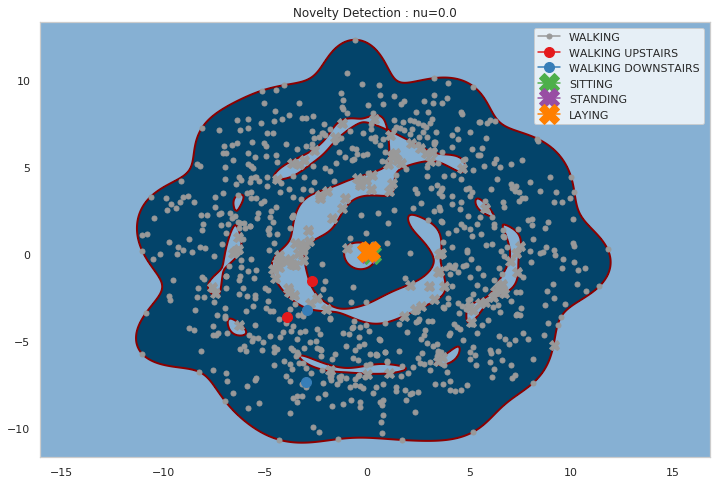

In [71]:
X_acp = X_acp_signal
nu = 0.02

# fit the model
clf = ssvm.OneClassSVM(kernel="rbf",nu=nu, gamma=1e-1)
clf.fit(X_acp[:,:2])
y_pred_train = clf.predict(X_acp[:,:2])


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

markersizes = [10 if y==1 else 20 for y in Y]
labels = [""] * N 
for il, l in [(np.where(Y_label==y)[0][0],y) for y in set(Y_label)]:
    labels[il] = l

uil.plot_decision_function(fig, ax, clf, X_acp, y_pred_train, colors=colors, labels = labels, markersizes=markersizes)
ax.set_title("Novelty Detection : nu=%.1f" %nu)


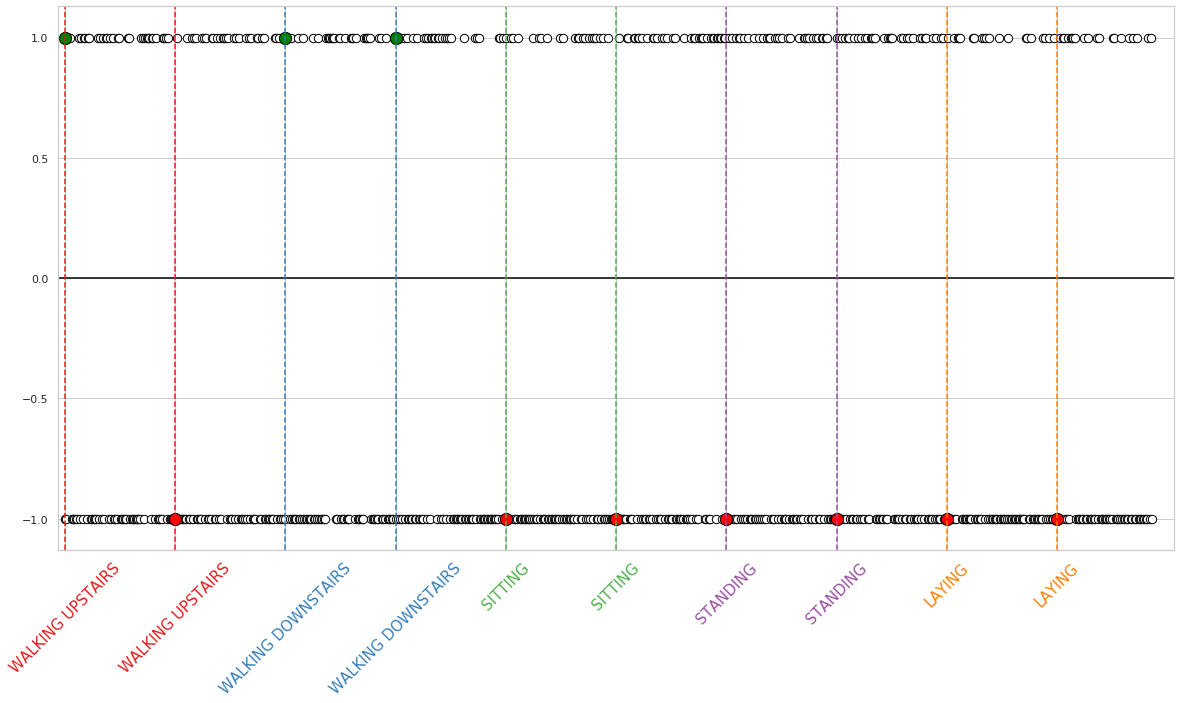

In [72]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_svm, COLOR_DIC, normal_behaviour="WALKING")


### 4.2.2 On the acceleration in x :

In [74]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(X_signaux)
pred = OCS.predict(X_signaux)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       43                   0   
 1            2        2         2      757                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Comment on the results. Does applying the method on all the signals improve the results?

**R** Bizarrement c'est toujours aussi nul, et avec tout le monde aussi.

## 4.3 Local Outlier Factor

### 4.3.1 On the acceleration in  x : 

In [75]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_signal)

CT_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof.pred, CT_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

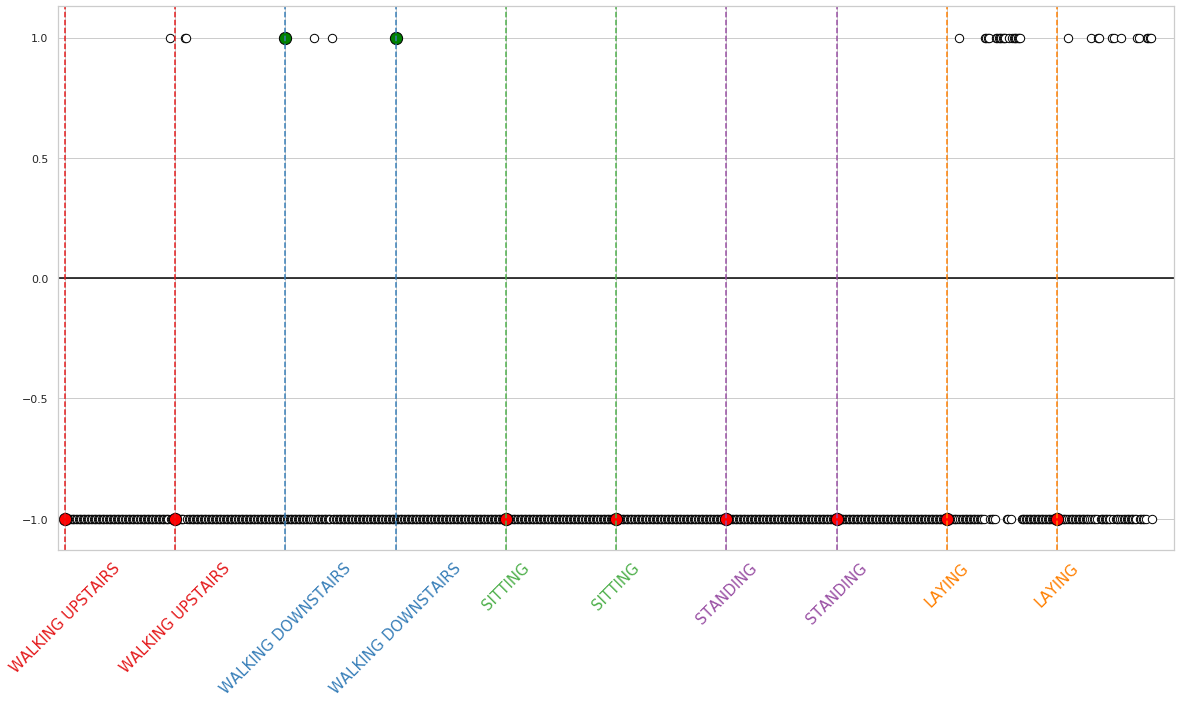

In [76]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_lof, COLOR_DIC, normal_behaviour="WALKING")


In [84]:
contamination=0.05
metric = "euclidean"
n_neighbors = 4
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_signaux)

CT_tous_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_tous_lof.pred, CT_tous_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       40                   1   
 1            2        2         2      760                   1   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Comment on the results. Do you get better performances on all the signals? By changing the parameters?

**R** Toujours pas mieux, avec très peu de voisins on détecte une anomalie mais bon...

### 4.3.2 On the PCA components : 

In [85]:
X_acp = X_acp_signal
n_neighbors = 15

# fit the model
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric = metric)
y_pred = clf.fit_predict(X_acp[:,:2])

CT_ACP_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof.pred, CT_ACP_lof.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

In [87]:
print(y_pred)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1
 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

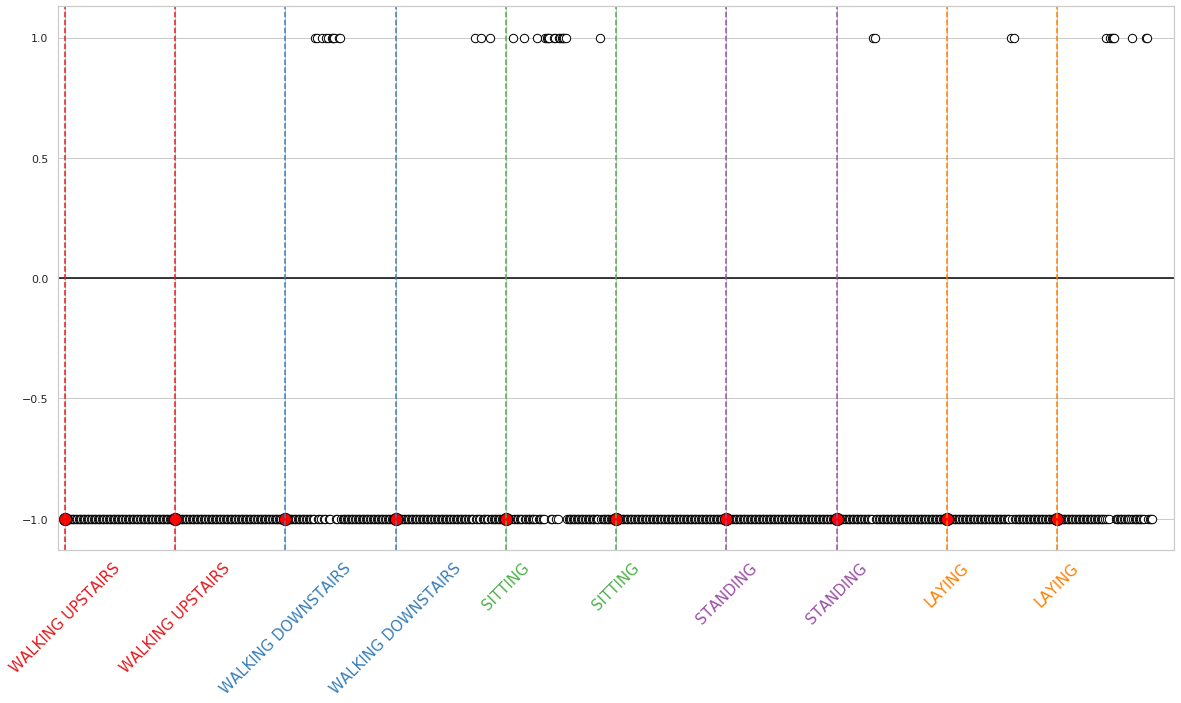

In [86]:

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_ACP_lof, COLOR_DIC, normal_behaviour="WALKING")

## Souci : les anomalies détectées ne s'affichent pas !


## 4.4 Isolation Forest

### 4.4.1 On the acceleration in  x :

In [88]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)


clf.fit(X_signal)
y_pred = clf.predict(X_signal)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

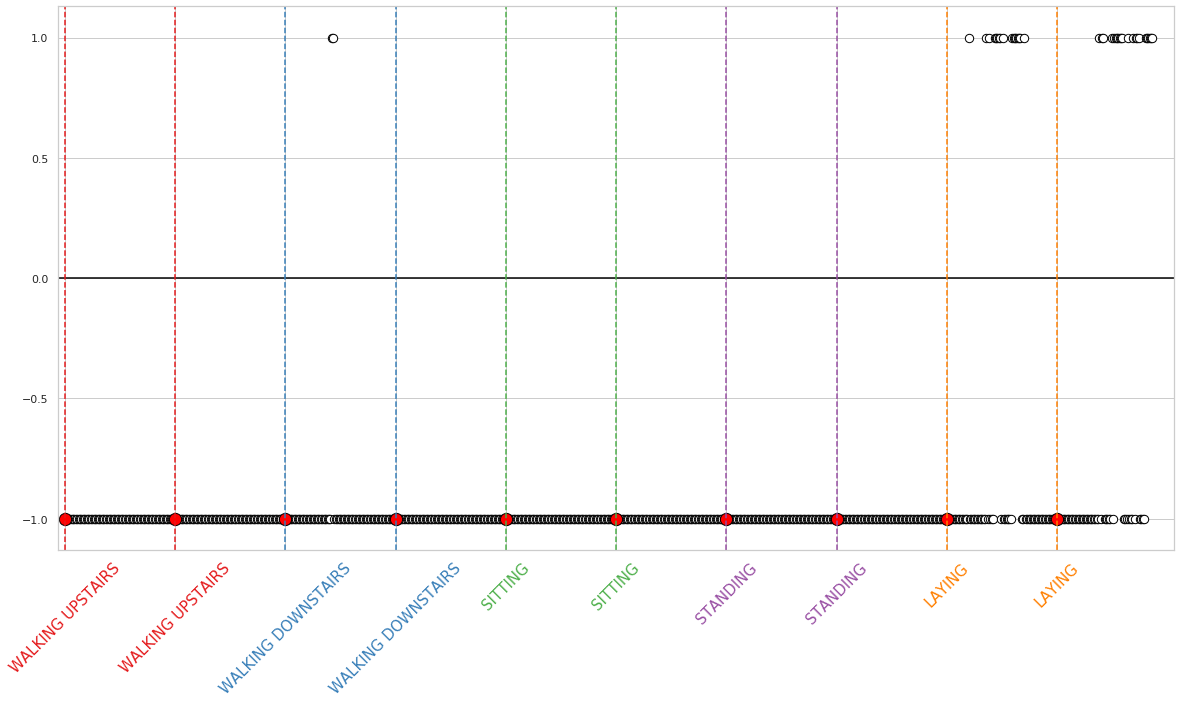

In [89]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_IF, COLOR_DIC, normal_behaviour="WALKING")


### 4.4.2 On the PCA components

In [99]:
X_acp = X_acp_signal

contamination=0.05
clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
nb_compo = 4
clf.fit(X_acp[:,:nb_compo])
y_pred = clf.predict(X_acp[:,:nb_compo])

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))



/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do you get better results by increasing the number of PCA components ? 

**R** En prendre 5 ou 6 permet d'attraper les deux anomalies walking downstairs.

**In conclusion**, the anomaly detection methods applied directly to the signals do not work well. We will see in the next section if the projection onto a wavelet basis allows to obtain better results. 

# 5. Anomaly detection based  wavelet decompositions of the signals


## 5.1 Wavelet decomposition

We work with the acceleration in x.  

In [100]:
import pywt
from pywt import wavedec

from statsmodels.robust import mad

In [101]:
isignal = 0
print(" signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

 signal body_acc_x


In [102]:

wf = "haar"

Coeff = []
TCoeff = []
for x in X_signal :
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=7)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(128))
    # Apply Threshold on 4 last levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(810, 128) (810, 128)
103680 26739


We only keep the coefficients from levels 1 to 4, the others are considered as noise and are canceled.

In [103]:
#Coefficients dfrom levels  1 to 4 : 
CoeffA4=Coeff[:,:16]

## 5.2 PCA of the wavelet coefficients

In [104]:
acp = sd.PCA()
X_acp_ond = acp.fit_transform(sp.scale(Coeff))


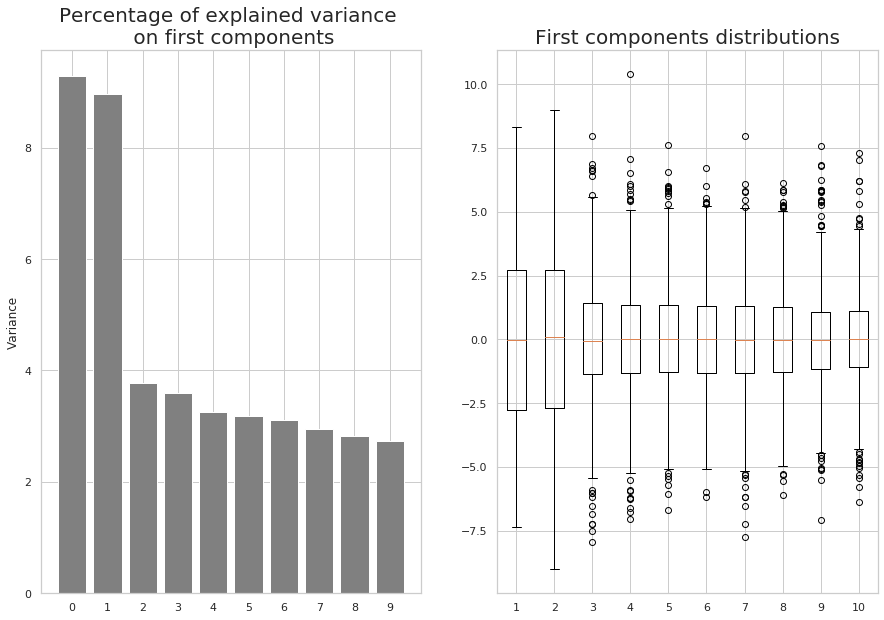

In [105]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_ond)

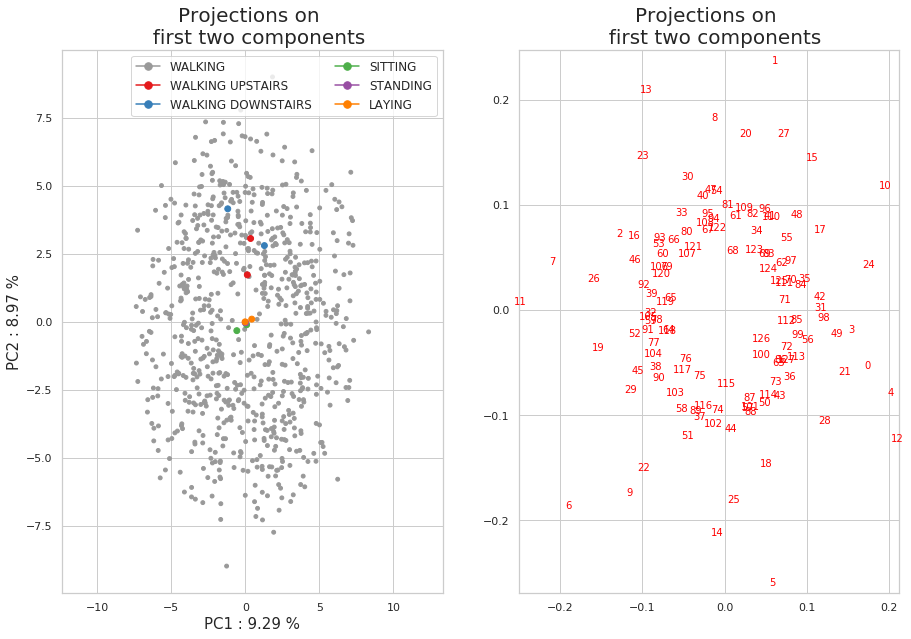

In [106]:
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_ond, acp, colors, markersizes, color_dic=COLOR_DIC)

## 5.3 PCA of the wavelet coefficients from levels 1 to 4 :  

In [107]:
acp = sd.PCA()
X_acp_ondA4 = acp.fit_transform(sp.scale(CoeffA4))

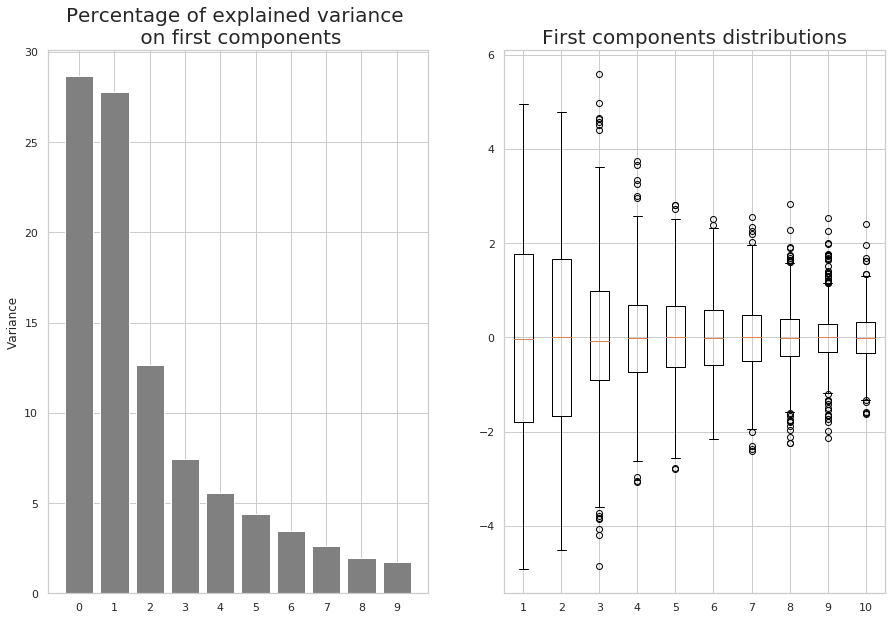

In [108]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_ondA4)

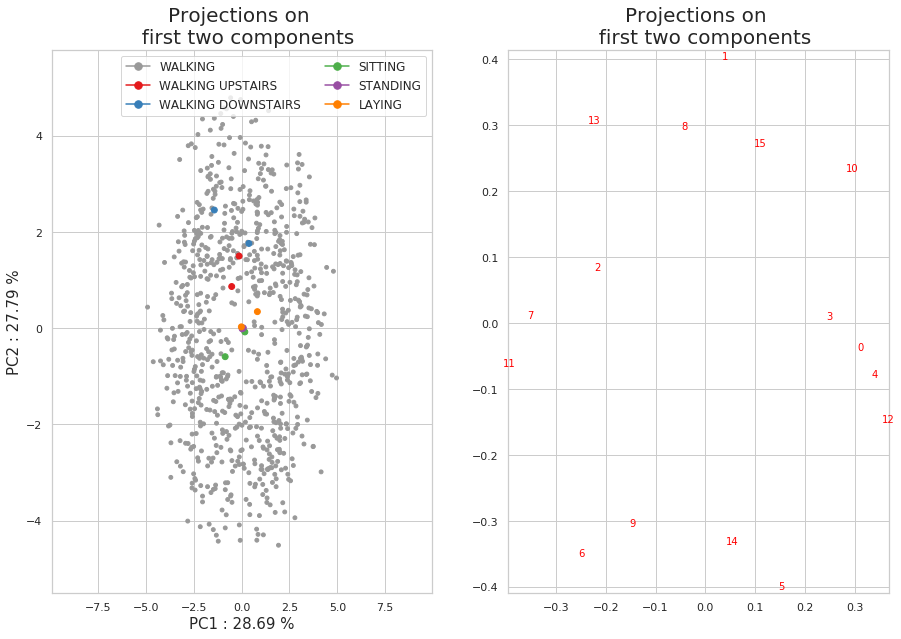

In [109]:
markersizes = [60 if y==1 else 140 for y in Y]
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_ondA4, acp, colors, markersizes, color_dic=COLOR_DIC)

**Q** Comment these results in the perspective of anomaly detection.

**R** Pas de séparation des anomalies, on aime pas.

## 5.4 Hierarchical clustering

In [110]:
Z = sch.linkage(Coeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             2        2         2      793                   2   
1             0        0         0        3                   0   
2             0        0         0        1                   0   
3             0        0         0        1                   0   
4             0        0         0        1                   0   
5             0        0         0        1                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

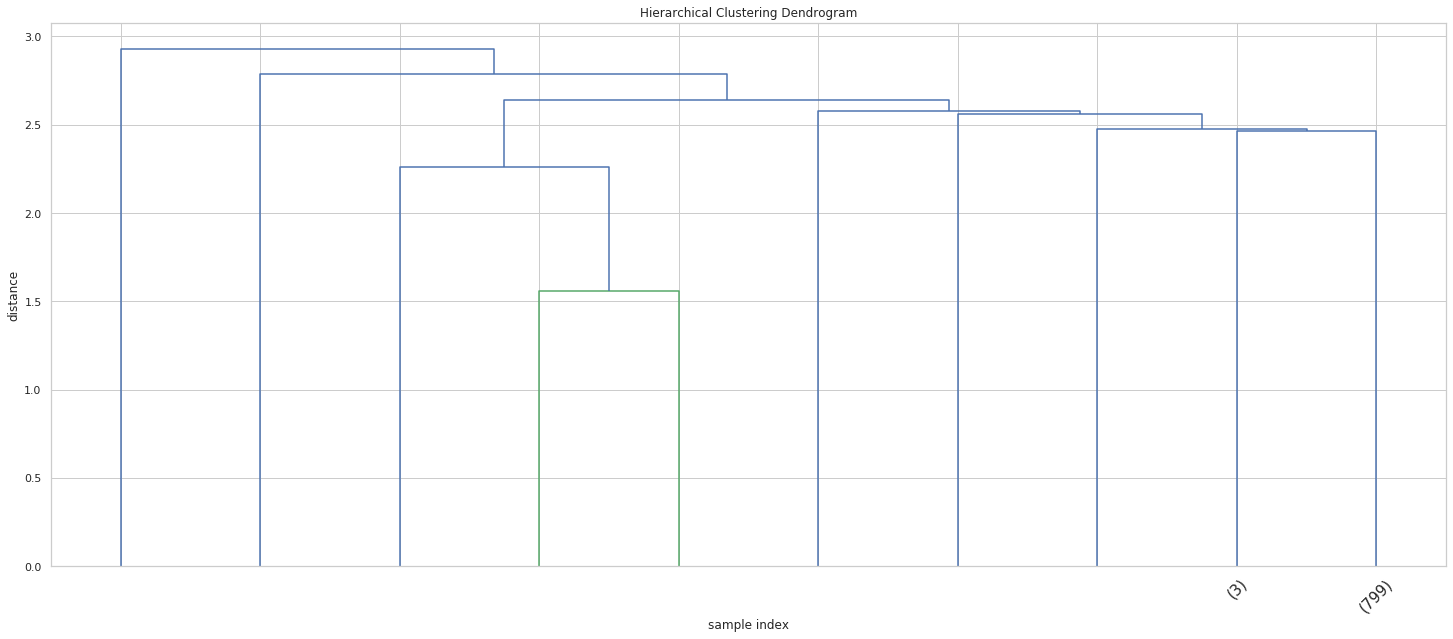

In [111]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

## 5.5 One class SVM

### 5.5.1 On all the coefficients

In [114]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="rbf", nu=0.05)

OCS.fit(Coeff)
pred = OCS.predict(Coeff)

CT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm.pred, CT_svm.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       41                   0   
 1            2        2         2      759                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do we get better results with thresholded coefficients? With the coefficients of level 1 to 4?

**R** Ehhh ben non toujours pas.

## 5.6 Local Outlier Factor

### 5.6.1 On the coefficients from  levels  1 to 4

In [120]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(CoeffA4)

CT_ond_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_ond_lof.pred, CT_ond_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

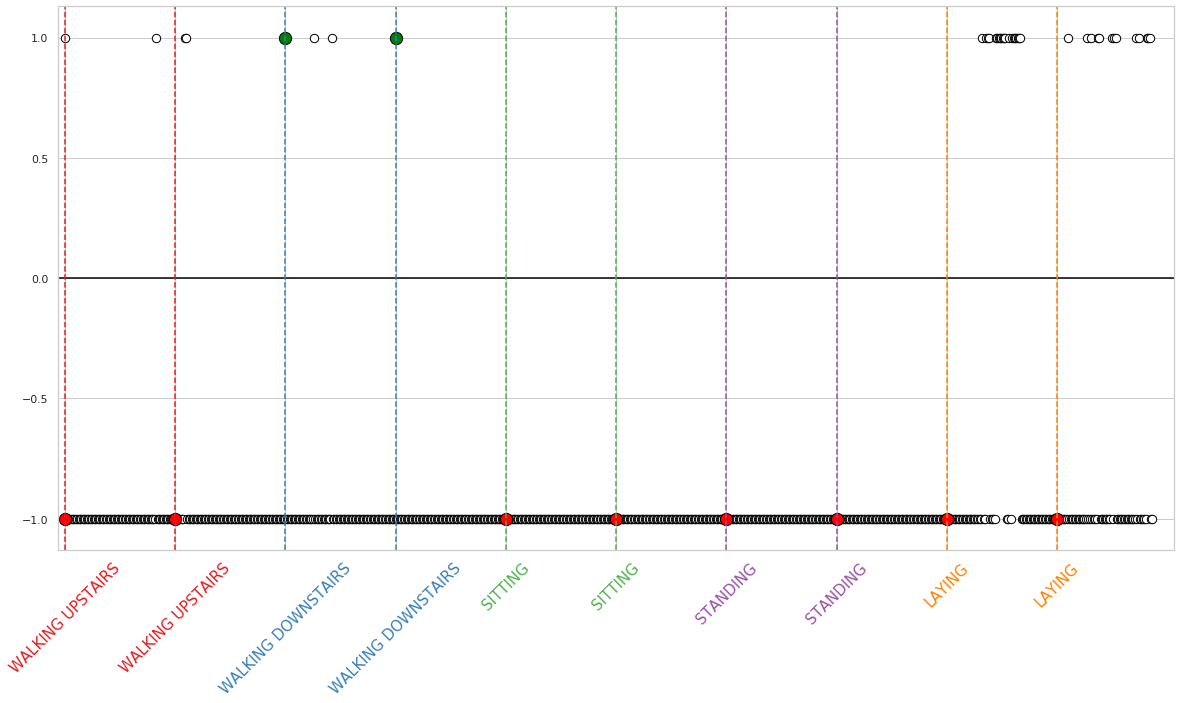

In [119]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_ond_lof, COLOR_DIC, normal_behaviour="WALKING")

**Q.** Do you get better results with all the coefficients? With the thresholded coefficients? With higher level coefficients?

**R** Ils sont tous aussi mauvais, pas de jaloux.

## 5.7 Isolation Forest

### 5.7.1 On all the coefficients

In [123]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)

clf.fit(CoeffA4)
y_pred = clf.predict(CoeffA4)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            0        0         0       39                   2   
 1            2        2         2      761                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Do we get better results with thresholded coefficients? With the coefficients of levels 1 to 4?

**R** Seuillés pas mieux, niveaux 1 à 4 un poil mieux, on retrouve Walking Downstairs.

**Q.** We only worked on the acceleration in x. Does considering all the signals improve the results?

**R** Flemme de tester mais je suppose que non.

**Conclusion :** The anomaly detection methods that we have considered, applied on wavelet transformations of the raw signals, do not detect anomalies. In the next section, we will see if the Fourier transform allows to improve the results.

# 6. Anomaly detection with the FFT coefficients
## 6.1 Computation of the FFT coefficients

In [124]:
# FFT Coefficients : 

from scipy.fftpack import fft

isignal = 0
print(" signal " + SIGNALS[isignal])
X_signal = np.vstack([x[:,isignal] for x in X])

#print(amplitudefft)
#plt.plot(amplitudefft)

fftCoeff = []

for x in X_signal :
    
    mx=np.mean(x)
    x_centre=x-mx
   #Apply fast Fourier transform
    coeffsfft=np.abs(fft(x_centre))  
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
        
fftCoeff = np.array(fftCoeff)

# Just keep half of the coefficients (they are then repeated symmetrically)

fftCoeff=fftCoeff[:,:64]
print(fftCoeff.shape)
print(np.sum(fftCoeff!=0))

 signal body_acc_x
(810, 64)
51816


## 6.2 PCA of the FFT coefficients

In [125]:
acp = sd.PCA()
X_acp_fft = acp.fit_transform(sp.scale(fftCoeff))


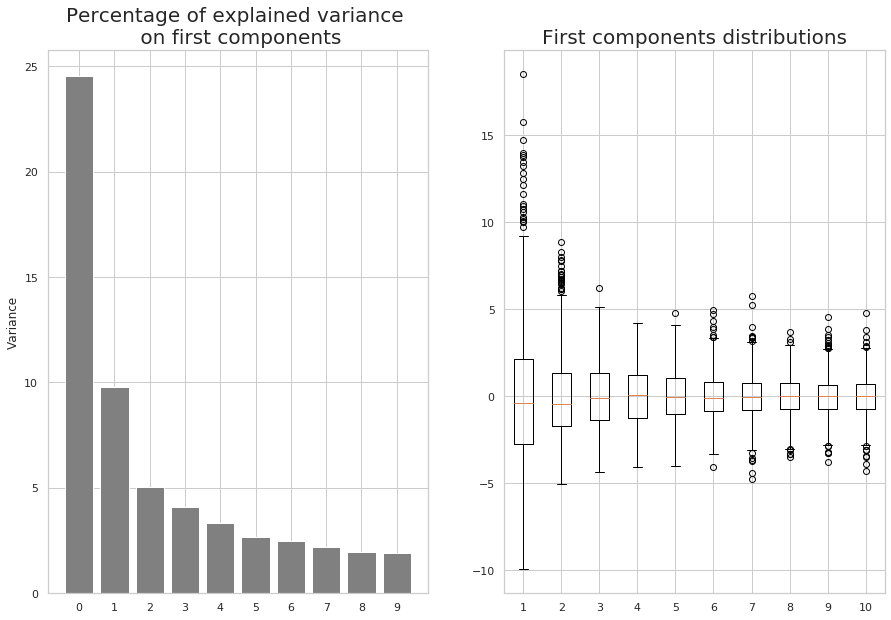

In [126]:
fig = plt.figure(figsize=(15,10))
uil.plot_variance_acp(fig, acp, X_acp_fft)

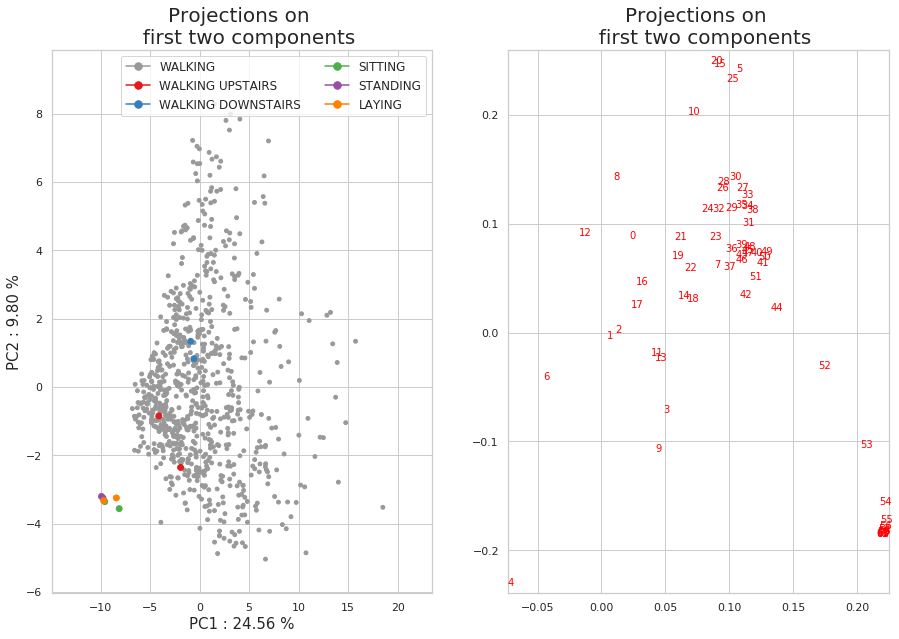

In [127]:
fig = plt.figure(figsize=(15,10))
uil.plot_projection_acp(fig, X_acp_fft, acp, colors, markersizes, color_dic=COLOR_DIC)

**Q.** Which signals differ from the others? Is this consistent with what has been seen in the previous notebook?

**R** Les signaux correspondant aux anomalies de repos se distinguent des autres, c'est cohérent avec les résultats obtenus sur les features métier.

## 6.3 Hierarchical clustering

In [128]:
Z = sch.linkage(fftCoeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,6)])

CT_HCA = pd.DataFrame(list(zip(C,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_HCA.pred, CT_HCA.Anomaly))

Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
0             0        0         0      794                   2   
1             0        0         0        1                   0   
2             0        0         0        1                   0   
3             0        0         0        3                   0   
4             0        0         0        1                   0   
5             2        2         2        0                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
0                       2  
1                       0  
2                       0  
3                       0  
4                       0  
5                       0

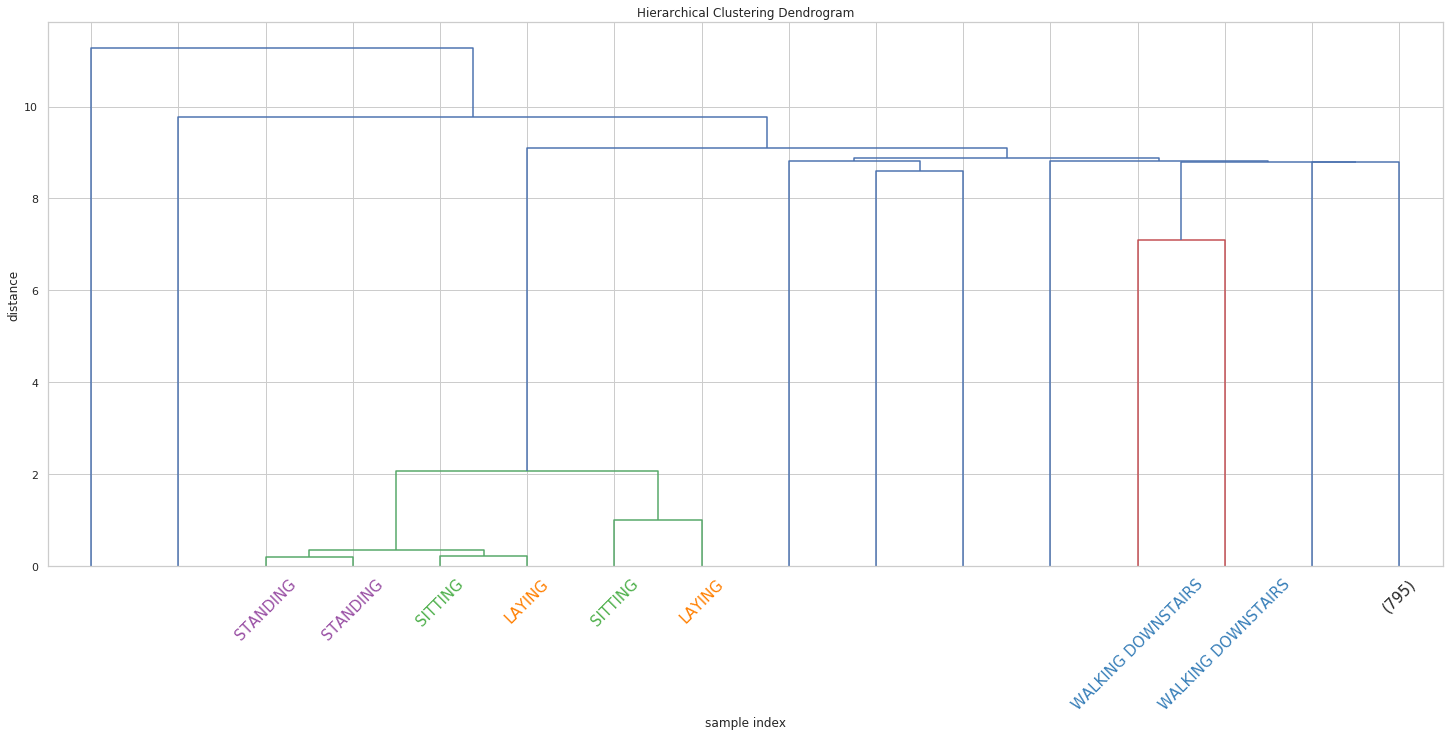

In [129]:
LABELS = ["" if y=="WALKING" else y for y in Y_label]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=6, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() in COLOR_DIC:
        lbl.set_color(COLOR_DIC[lbl.get_text()])


plt.show()

**Q** Comment the results. 

**R** C'st moins bien que les features métier mais mieux que les ondelettes.

## 6.4 One class SVM

In [146]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(kernel="poly", nu=0.05)

OCS.fit(fftCoeff)
pred = OCS.predict(fftCoeff)

CT_FFT_svm = pd.DataFrame(list(zip(pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_FFT_svm.pred, CT_FFT_svm.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       34                   0   
 1            0        0         0      766                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2

**Q.** Study the impact of the kernel and of the parameter nu. 

**R** Le kernel influe un peu, poly et linear marchent mieux que rbf.

## 6.5 Local Outlier Factor

In [142]:
contamination=0.05
metric = "euclidean"
n_neighbors = 15
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(fftCoeff)

CT_FFT_lof = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_FFT_lof.pred, CT_FFT_lof.Anomaly))


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            2        2         2       32                   2   
 1            0        0         0      768                   0   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      1  
 1                      1

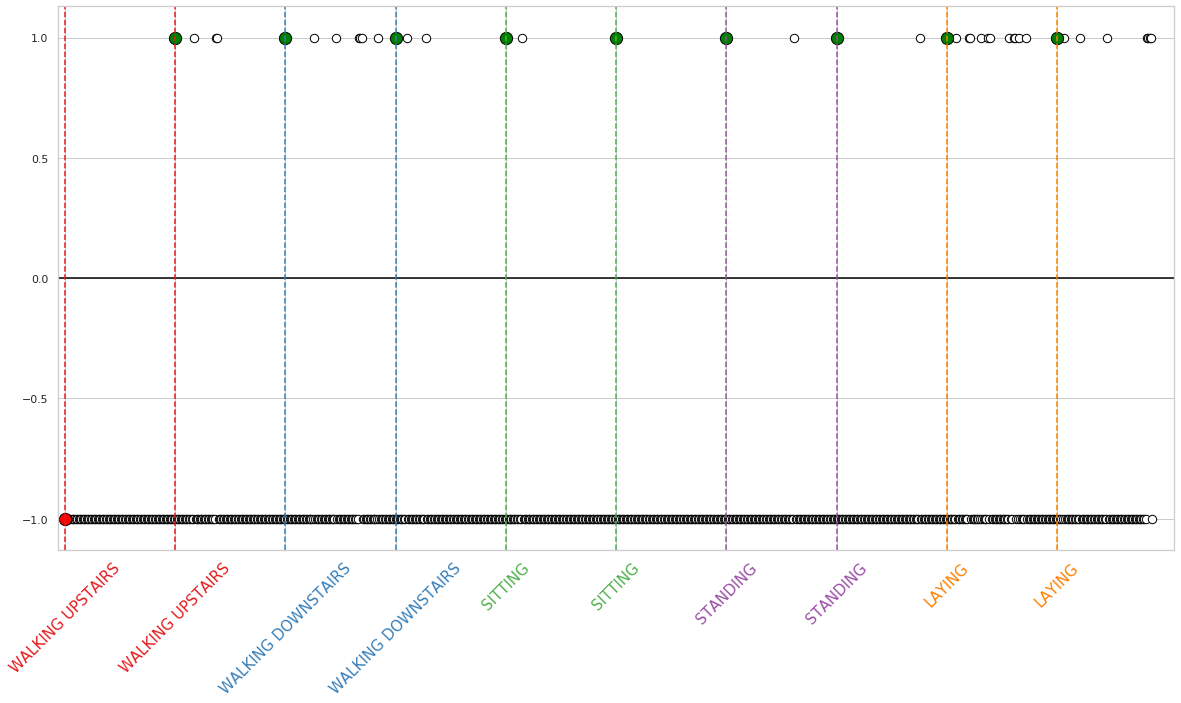

In [143]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
uil.plot_detection_result(fig, ax, CT_FFT_lof, COLOR_DIC, normal_behaviour="WALKING")


**Q.** Comment on the results and see the impact of the parameters. 

**R** Ohhh bonheur enfin un truc honnête, ça faisait longtemps ! On a presque aussi bien que sur les features.

## 6.5 Isolation Forest

In [147]:
clf = se.IsolationForest(n_estimators=100, contamination=0.05, bootstrap=True, n_jobs=-1)

clf.fit(fftCoeff)
y_pred = clf.predict(fftCoeff)

CT_IF = pd.DataFrame(list(zip(y_pred,Y_label)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF.pred, CT_IF.Anomaly))

/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/insa/anaconda/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Anomaly  LAYING  SITTING  STANDING  WALKING  WALKING DOWNSTAIRS  \
pred                                                              
-1            1        1         2       37                   0   
 1            1        1         0      763                   2   

Anomaly  WALKING UPSTAIRS  
pred                       
-1                      0  
 1                      2


## 6.7 Visualisation of the  LOF results

The LOF method is one of the most powerful whatever the type of "features" considered. The results of this method are visualized for the various cases considered in the notebook.


Text(0.5, 1.0, 'FFT coefficients')

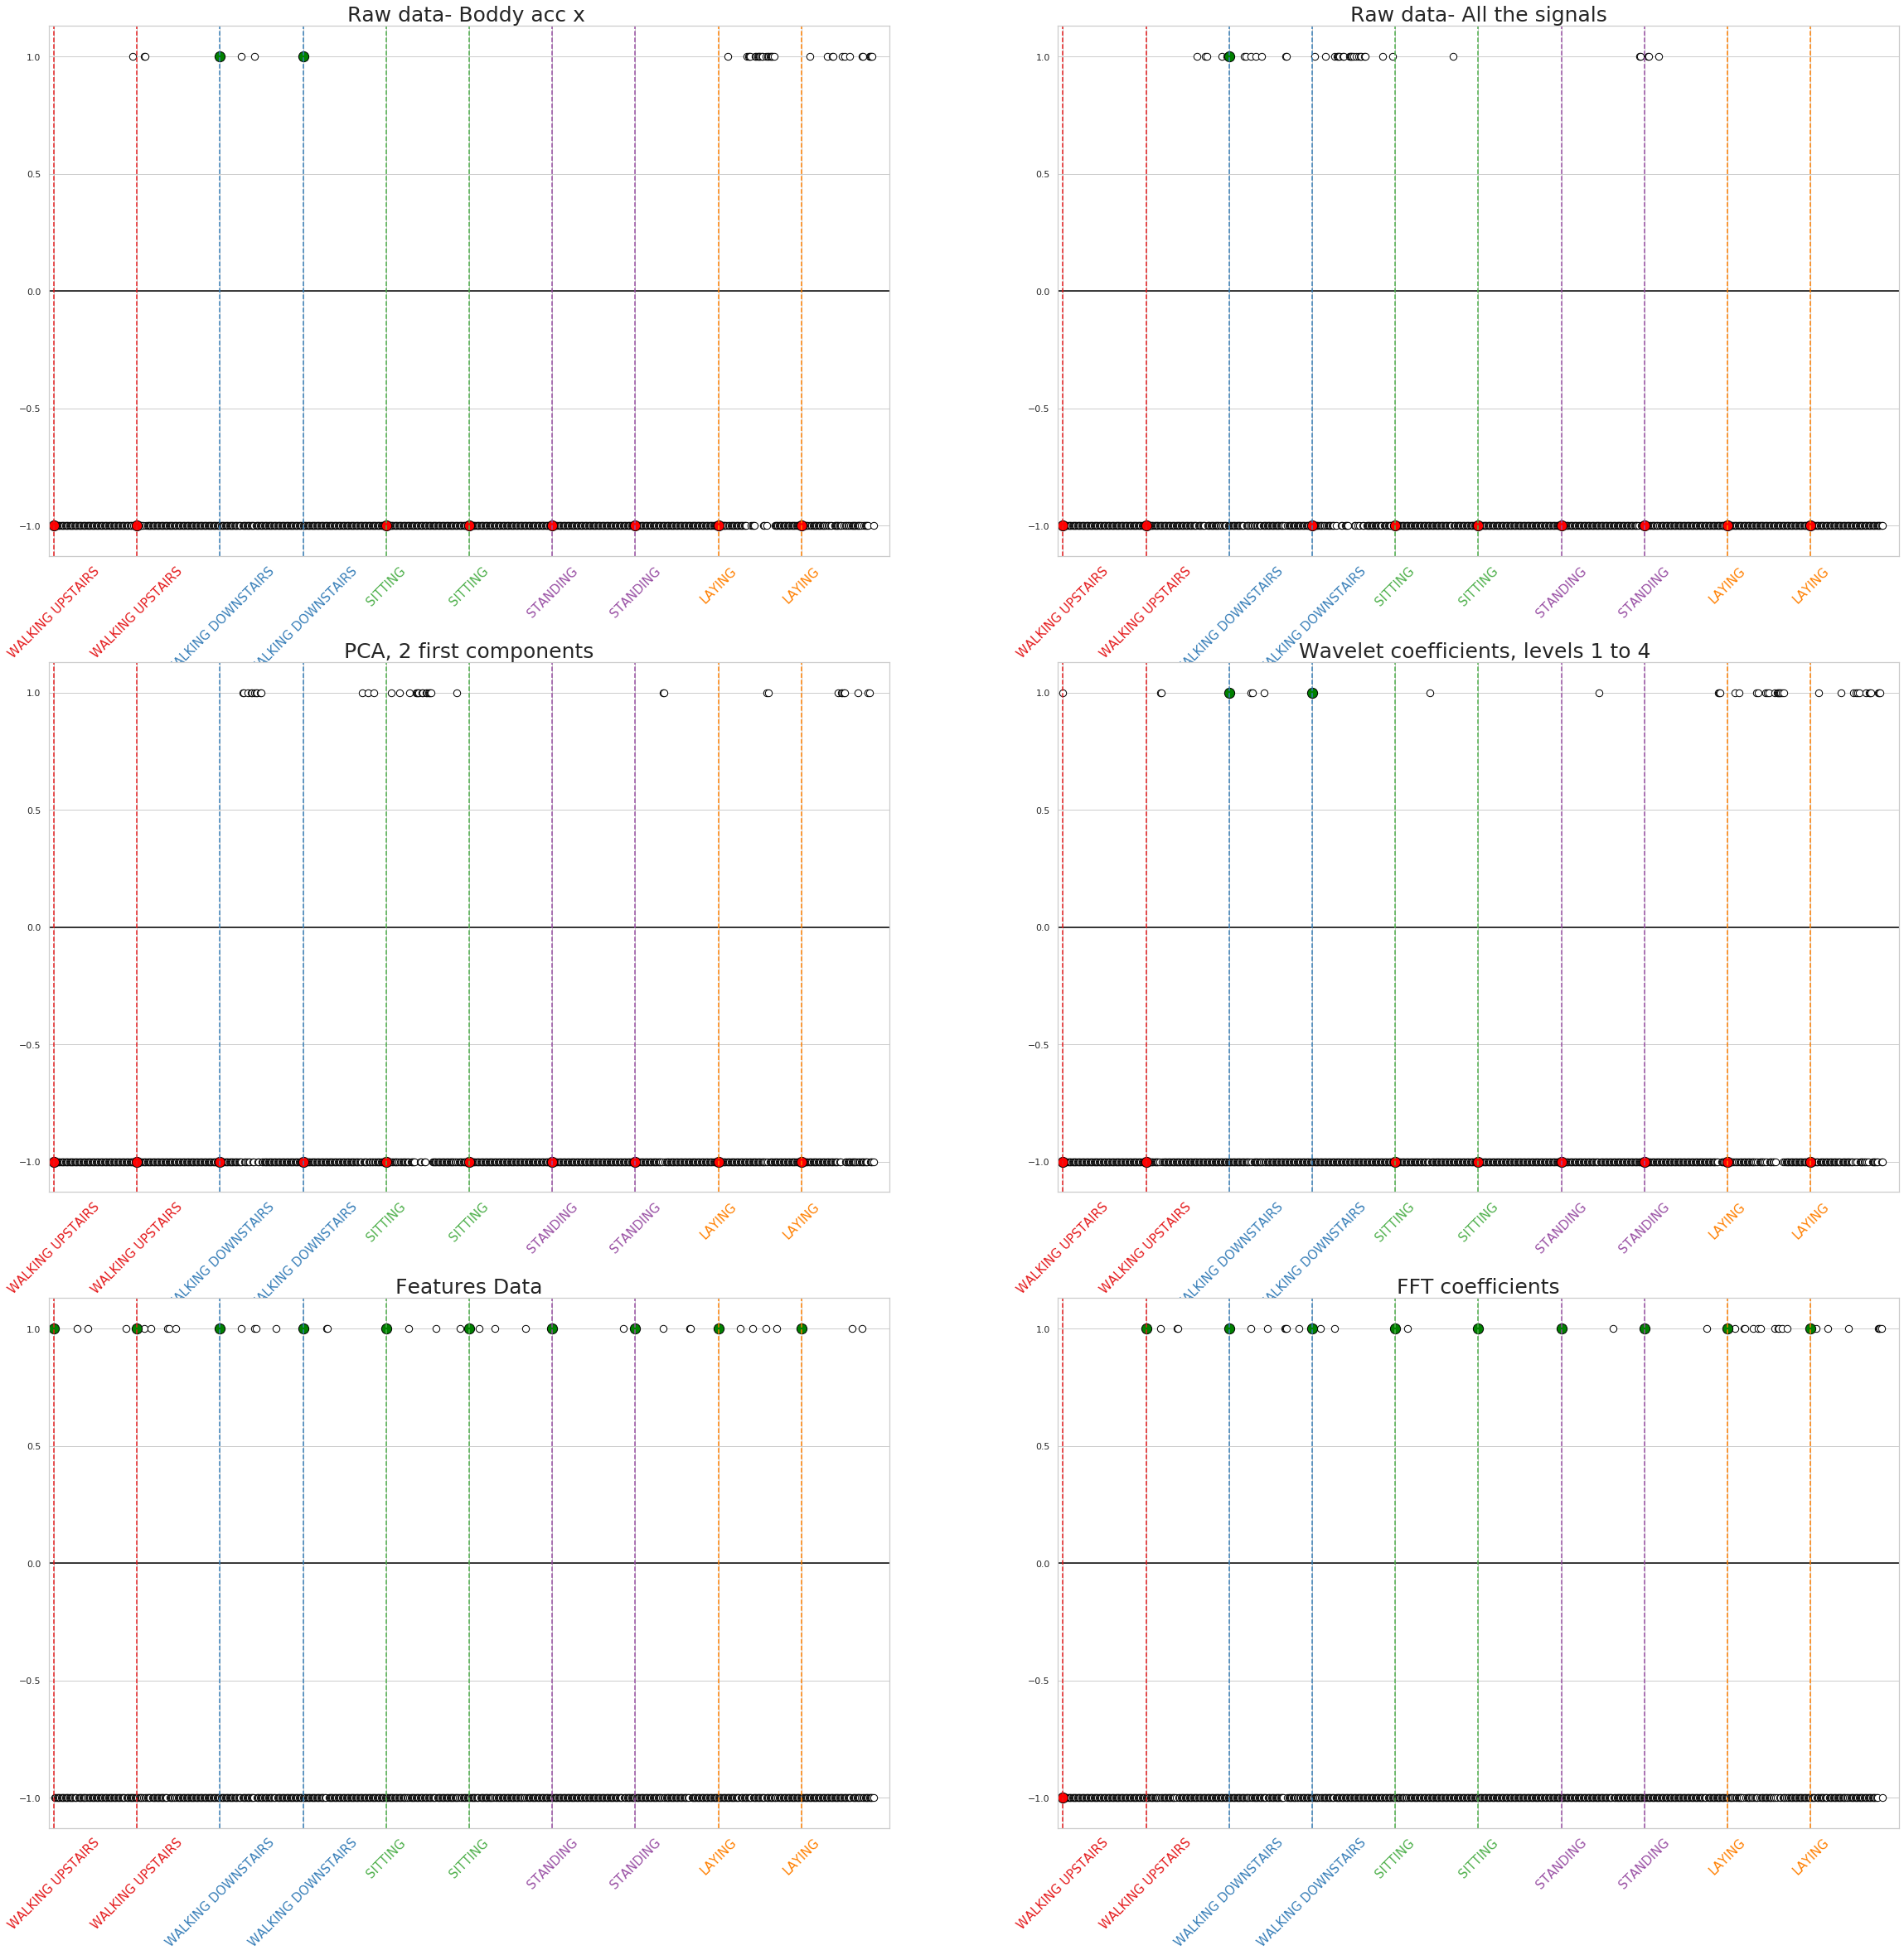

In [148]:
fig = plt.figure(figsize=(40,40))
ax = fig.add_subplot(3,2,1)
uil.plot_detection_result(fig, ax, CT_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Raw data- Boddy acc x ", fontsize=25)
ax = fig.add_subplot(3,2,2)
uil.plot_detection_result(fig, ax, CT_tous_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Raw data- All the signals", fontsize=25)
ax = fig.add_subplot(3,2,3)
uil.plot_detection_result(fig, ax, CT_ACP_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("PCA, 2 first components", fontsize=25)
ax = fig.add_subplot(3,2,4)
uil.plot_detection_result(fig, ax, CT_ond_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Wavelet coefficients, levels 1 to 4 ", fontsize=25)
ax = fig.add_subplot(3,2,5)
uil.plot_detection_result(fig, ax, CT_metier_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("Features Data", fontsize=25)
ax = fig.add_subplot(3,2,6)
uil.plot_detection_result(fig, ax, CT_FFT_lof, COLOR_DIC, normal_behaviour="WALKING")
ax.set_title("FFT coefficients", fontsize=25)

# 7. Conclusion

We have studied various methods for anomaly detection. On the *features* data, it is quite easy  to detect the anomalies. On the functional raw data, we have seen the importance of defining good "features" to highlight the anomalies: the methods of detection of anomalies applied to the raw signals or their wavelet transform, have certainly not been totally optimized but do not give good results in this case. On the other hand, the Fast Fourier Transform highlights the anomalies for these data. We can not draw a generality : on simulated telemetry data of the available notebook [here](https://github.com/wikistat/High-Dimensional-Deep-Learning/blob/master/AnomalyDetection/Python-Anomaly-Detection.ipynb), the transformation onto a wavelet basis is relevant for the detection of anomalies for these functional data. It is therefore important to know the data and the type of anomalies that you want to detect.
